In [2]:
# Import libraries and set desired options
%matplotlib inline
from matplotlib import pyplot as plt

import pickle
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

Notebook by Yuri Kashnitsky, edited by Ivan Komarov. 

In this competition we are going to analyze a sequence of websites visited by a person to predict whether this person is Alice or not. The metric of evaluation is [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). 

###  Data Downloading and Transformation
First, read the training and test sets. 

In [3]:
times = ['time'+str(i) for i in range(1,11)]
times

['time1',
 'time2',
 'time3',
 'time4',
 'time5',
 'time6',
 'time7',
 'time8',
 'time9',
 'time10']

In [4]:
# Read the training and test data sets and parse dates
train_df = pd.read_csv('train.csv',
                       index_col='session_id', parse_dates=times)

test_df = pd.read_csv('test.csv',
                      index_col='session_id', parse_dates=['time1'])

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
27554,41475,2013-11-15 07:39:35,6725.0,2013-11-15 07:39:35,6725.0,2013-11-15 07:39:36,41475.0,2013-11-15 07:39:36,41476.0,2013-11-15 07:39:40,...,2013-11-15 07:39:41,6725.0,2013-11-15 07:42:50,41475.0,2013-11-15 07:42:50,41476.0,2013-11-15 07:42:50,6725.0,2013-11-15 07:44:25,0
81350,41476,2013-11-15 07:44:25,41475.0,2013-11-15 07:44:25,41476.0,2013-11-15 07:57:45,6725.0,2013-11-15 07:57:45,41475.0,2013-11-15 07:57:45,...,2013-11-15 07:57:46,41476.0,2013-11-15 07:57:47,6725.0,2013-11-15 07:57:49,41475.0,2013-11-15 07:57:49,41476.0,2013-11-15 07:57:49,0
234665,4802,2013-11-15 07:52:17,23.0,2013-11-15 07:52:18,4803.0,2013-11-15 07:52:19,38.0,2013-11-15 07:52:19,38.0,2013-11-15 07:52:20,...,2013-11-15 07:52:20,4804.0,2013-11-15 07:52:23,21.0,2013-11-15 07:52:26,23.0,2013-11-15 07:52:26,22.0,2013-11-15 07:52:28,0
97610,23,2013-11-15 07:52:28,23.0,2013-11-15 07:52:29,22.0,2013-11-15 07:52:37,21.0,2013-11-15 07:52:37,63.0,2013-11-15 07:55:10,...,2013-11-15 07:55:10,784.0,2013-11-15 07:55:56,4804.0,2013-11-15 07:57:50,4804.0,2013-11-15 08:01:18,784.0,2013-11-15 08:01:26,0
161358,41476,2013-11-15 07:57:50,41476.0,2013-11-15 07:57:51,6725.0,2013-11-15 07:59:34,41475.0,2013-11-15 07:59:34,41476.0,2013-11-15 07:59:34,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 27554 to 11690
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  d

The training data set contains the following features:

- **site1** – ID of the first visited website in the session
- **time1** – visiting time for the first website in the session
- ...
- **site10** – ID of the tenth visited website in the session
- **time10** – visiting time for the tenth website in the session
- **target** – target variable, equals 1 for Alice's sessions, and 0 otherwise
    
**User sessions end either if a user has visited ten websites or if a session has lasted over thirty minutes.**

There are some empty values in the table, it means that some sessions contain less than ten websites. Replace empty values with 0 and change columns types to integer. Also load the websites dictionary and check how it looks:

In [6]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site'+str(i) for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)
    
# r before a string means "raw", i.e. take the string as it comes,
# e.g. as a file path without interpreting special symbols like \n

print('Websites total:', len(site_dict))



Websites total: 48371


In [7]:
# See what's in the dict
list(site_dict.items())[:3]

[('www.abmecatronique.com', 25075),
 ('groups.live.com', 13997),
 ('majeureliguefootball.wordpress.com', 42436)]

In [8]:
# Size of the sets
print(test_df.shape, train_df.shape)

(82797, 20) (253561, 21)


In [9]:
# What's inside the train
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
27554,41475,2013-11-15 07:39:35,6725,2013-11-15 07:39:35,6725,2013-11-15 07:39:36,41475,2013-11-15 07:39:36,41476,2013-11-15 07:39:40,...,2013-11-15 07:39:41,6725,2013-11-15 07:42:50,41475,2013-11-15 07:42:50,41476,2013-11-15 07:42:50,6725,2013-11-15 07:44:25,0
81350,41476,2013-11-15 07:44:25,41475,2013-11-15 07:44:25,41476,2013-11-15 07:57:45,6725,2013-11-15 07:57:45,41475,2013-11-15 07:57:45,...,2013-11-15 07:57:46,41476,2013-11-15 07:57:47,6725,2013-11-15 07:57:49,41475,2013-11-15 07:57:49,41476,2013-11-15 07:57:49,0
234665,4802,2013-11-15 07:52:17,23,2013-11-15 07:52:18,4803,2013-11-15 07:52:19,38,2013-11-15 07:52:19,38,2013-11-15 07:52:20,...,2013-11-15 07:52:20,4804,2013-11-15 07:52:23,21,2013-11-15 07:52:26,23,2013-11-15 07:52:26,22,2013-11-15 07:52:28,0
97610,23,2013-11-15 07:52:28,23,2013-11-15 07:52:29,22,2013-11-15 07:52:37,21,2013-11-15 07:52:37,63,2013-11-15 07:55:10,...,2013-11-15 07:55:10,784,2013-11-15 07:55:56,4804,2013-11-15 07:57:50,4804,2013-11-15 08:01:18,784,2013-11-15 08:01:26,0
161358,41476,2013-11-15 07:57:50,41476,2013-11-15 07:57:51,6725,2013-11-15 07:59:34,41475,2013-11-15 07:59:34,41476,2013-11-15 07:59:34,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0


For the very basic model, we will use only the visited websites in the session (we will not take into account timestamp features). 

*Alice has her favorite sites, and the more often you see these sites in the session, the higher probability that this is an Alice session, and vice versa.*

Let us prepare the data, we will take only features `site1, site2, ... , site10` from the whole dataframe. Keep in mind that the missing values are replaced with zero. Here is what the first rows of the dataframe look like:

In [10]:
train_df[sites].head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
27554,41475,6725,6725,41475,41476,41476,6725,41475,41476,6725
81350,41476,41475,41476,6725,41475,41476,41476,6725,41475,41476
234665,4802,23,4803,38,38,4804,4804,21,23,22
97610,23,23,22,21,63,66,784,4804,4804,784
161358,41476,41476,6725,41475,41476,0,0,0,0,0


Since IDs of sites have no meaning (does not matter if a site has an ID of 1 or 100), we need to think about how to encode the meaning of "this site in a session means higher probablity that it is an Alice session". 

We will use a technique called ["bag of words plus n-gram model"](https://en.wikipedia.org/wiki/Bag-of-words_model).

We will make a "site-session" matrix analogous to the term-document matrix.

We are not the first, and luckily there is a function CountVectorizer that will implement the above model. Type help(CountVectorizer) to learn about the function. 

We will now initialize a "cv" (CountVectorizer's) instance which we need to train. 

We will use the following parameters:

_ngram range=(1, 3)_ - here we decide that we will use 
1) the name of the site, 
2) two consecutive site names, and 
3) three consecutive site names as features. 
E.g. "google.com" or "google.com vk.com" or "google.com vk.com groups.live.com". 

CountVectorizer will create a large dictionary of 1, 2, and 3-gram strings of sites represented by their numerical IDs. However, this dictionary will be so so large that we may run into trouble with memory or we will just be inefficent chasing phantom combinations.

We will thus limit the dictionary to 50K of the most frequent n-grams:

_max features=50000_

Here is our empty instance:

In [11]:
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)

CountVectorizer accepts "document strings", so let's prepare a string of our "documents" (i.e. sites), divided by space. Since the string will be huge, we will write this string in a text file using pandas:

In [12]:
train_df[sites].fillna(0).to_csv('train_sessions_text.txt', 
                                 sep=' ', index=None, header=None)
test_df[sites].fillna(0).to_csv('test_sessions_text.txt', 
                                sep=' ', index=None, header=None)

Before we start using CountVectorizer, let's see how it works on a sub-set of 5 sessions:

In [13]:
five_sess = pd.read_csv('train_sessions_text.txt', sep=' ', nrows=5, header=None)

In [14]:
five_sess

,0,1,2,3,4,5,6,7,8,9
0,41475,6725,6725,41475,41476,41476,6725,41475,41476,6725
1,41476,41475,41476,6725,41475,41476,41476,6725,41475,41476
2,4802,23,4803,38,38,4804,4804,21,23,22
3,23,23,22,21,63,66,784,4804,4804,784
4,41476,41476,6725,41475,41476,0,0,0,0,0


First of all, let's make an inverse dictionary which gives us a site name for ID.
The direct dictionary came to us like this:

In [15]:
list(site_dict.items())[:3]

[('www.abmecatronique.com', 25075),
 ('groups.live.com', 13997),
 ('majeureliguefootball.wordpress.com', 42436)]

In [16]:
# The inverse dictionary:

new_dict = {}
for key in site_dict:
    new_dict[site_dict[key]] = key

In [17]:
# Let's check what's in it:

list(new_dict.items())[:3]

[(25075, 'www.abmecatronique.com'),
 (13997, 'groups.live.com'),
 (42436, 'majeureliguefootball.wordpress.com')]

In [18]:
# Let's see site names in the five first sessions:

list_sites = []
for row in five_sess.values:
    row_sites = ' '.join([str(i) for i in row if i!=0])
    print(row_sites)
    list_sites.append(row_sites) 

print()
    
list_sites_names = []
for row in five_sess.values:
    row_sites = ' '.join([new_dict[i] for i in row if i!=0])
    print(row_sites)
    list_sites_names.append(row_sites)

41475 6725 6725 41475 41476 41476 6725 41475 41476 6725
41476 41475 41476 6725 41475 41476 41476 6725 41475 41476
4802 23 4803 38 38 4804 4804 21 23 22
23 23 22 21 63 66 784 4804 4804 784
41476 41476 6725 41475 41476

security.debian.org www-fourier.ujf-grenoble.fr www-fourier.ujf-grenoble.fr security.debian.org backports.debian.org backports.debian.org www-fourier.ujf-grenoble.fr security.debian.org backports.debian.org www-fourier.ujf-grenoble.fr
backports.debian.org security.debian.org backports.debian.org www-fourier.ujf-grenoble.fr security.debian.org backports.debian.org backports.debian.org www-fourier.ujf-grenoble.fr security.debian.org backports.debian.org
cnfg.toolbarservices.com www.google.com utils.delta-search.com ajax.googleapis.com ajax.googleapis.com img.babylon.com img.babylon.com www.google.fr www.google.com apis.google.com
www.google.com www.google.com apis.google.com www.google.fr ieonline.microsoft.com go.microsoft.com javadl-esd-secure.oracle.com img.babylon.com i

Here is what the fit and transform method -- i.e. learn the dictionary and make the matrix -- produces in our "cv":
a sparse matrix. Why sparse? Because nrows * dict_size = usually will not fit in memory 
(obviously, our 5 sessions will fit in memory so that we can look at them)

In [19]:
see_vect = cv.fit_transform(list_sites)

# Matrix dimensions: 5 sessions of 60 elements
see_vect

<5x60 sparse matrix of type '<class 'numpy.int64'>'
	with 88 stored elements in Compressed Sparse Row format>

In [20]:
# Here is the dictionary of sites, 1 to 3-gram words. First 6 elements in the matrix:

cv.get_feature_names()[:6]

C:\Users\Zetis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['21', '21 23', '21 23 22', '21 63', '21 63 66', '22']

In [21]:
# A version with the site names. Note that security.debian.org has ID of 21.

for i, string in enumerate(cv.get_feature_names()):
    if i < 21:
        print (i+1, end=" ")
        for num in string.split():
            print(new_dict[int(num)], end=" ")
        print()

1 www.google.fr 
2 www.google.fr www.google.com 
3 www.google.fr www.google.com apis.google.com 
4 www.google.fr ieonline.microsoft.com 
5 www.google.fr ieonline.microsoft.com go.microsoft.com 
6 apis.google.com 
7 apis.google.com www.google.fr 
8 apis.google.com www.google.fr ieonline.microsoft.com 
9 www.google.com 
10 www.google.com apis.google.com 
11 www.google.com apis.google.com www.google.fr 
12 www.google.com www.google.com 
13 www.google.com www.google.com apis.google.com 
14 www.google.com utils.delta-search.com 
15 www.google.com utils.delta-search.com ajax.googleapis.com 
16 ajax.googleapis.com 
17 ajax.googleapis.com ajax.googleapis.com 
18 ajax.googleapis.com ajax.googleapis.com img.babylon.com 
19 ajax.googleapis.com img.babylon.com 
20 ajax.googleapis.com img.babylon.com img.babylon.com 
21 security.debian.org 


In [22]:
# Here is the session-site matrix, toarrray() helps us to see a sparse matrix since it is not large.

see_vect.toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2,
        1, 1, 1, 1, 3, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,
        1, 1, 0, 0, 5, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 3, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 

In [23]:
# The first session (row in the matrix) is this:

list_sites_names[0]

'security.debian.org www-fourier.ujf-grenoble.fr www-fourier.ujf-grenoble.fr security.debian.org backports.debian.org backports.debian.org www-fourier.ujf-grenoble.fr security.debian.org backports.debian.org www-fourier.ujf-grenoble.fr'

Let's see how the first site of the first session, "security.debian.org", is recorded in the session-site matrix. 
Its ID is 21 which corresponds to 3. It is the number of times this site was seen in the first session.
Indeed, count for yourself in the cell above. 

In [24]:

first_row = see_vect.toarray()[0]

for one, two in zip(range(60),first_row):
    if one < 21:
        print (one+1, two)


1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 3


Let's go back to all sessions.

Fit `CountVectorizer` to train data and transform the train and test data with it.

In [25]:
%%time

with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)

print(X_train.shape, X_test.shape)

# Note very big dimensions of matrices: 253561 * 50000 = 12678050000 elements in train! Only sparse matrices can take it.

(253561, 50000) (82797, 50000)
CPU times: total: 8.67 s
Wall time: 8.69 s


### Training the first model

So, we have an algorithm and data for it. Let us build our first model, using [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation from ` Sklearn` with default parameters. We will use the first 90% of the data for training (the training data set is sorted by time) and the remaining 10% for validation. Let's write a simple function that returns the quality of the model and then train our first classifier:

In [26]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='lbfgs', max_iter=500).fit(X[:idx, :], y[:idx])
    
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [27]:
# Our target variable
y_train = train_df['target'].values

In [28]:
%%time
# Calculate metric on the validation set. 90% of train data for training. 10% for validation.

print(get_auc_lr_valid(X_train, y_train))

0.9122554756073407
CPU times: total: 7.58 s
Wall time: 7.25 s


In [29]:
# 50% of train data for training:

get_auc_lr_valid(X_train, y_train, ratio=0.5)

0.8225181151083711

In [30]:
# Wow! Big data rules in this task: .82 -> .91

In [31]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = range(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [32]:
# Train the model on the whole training data set
# Use random_state=17 for reproducibility
# Parameter C=1 by default, but here we set it explicitly

lr = LogisticRegression(C=1.0, random_state=17, solver='lbfgs', max_iter=500).fit(X_train, y_train)

# Make a prediction for test data set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

The first model demonstrated the quality of 0.9235 on the validation set. Let's take it as the first baseline and starting point. 

### Задание №1 Какой процент сессий Элис из всех сессий?

Всего сессий:

In [33]:
train_df['target'].count()

253561

In [48]:
train_df['target'].value_counts()  # Сессий где была (1) и НЕ была (0) Элис

0    251264
1      2297
Name: target, dtype: int64

In [35]:
2297 / 253561

0.00905896411514389

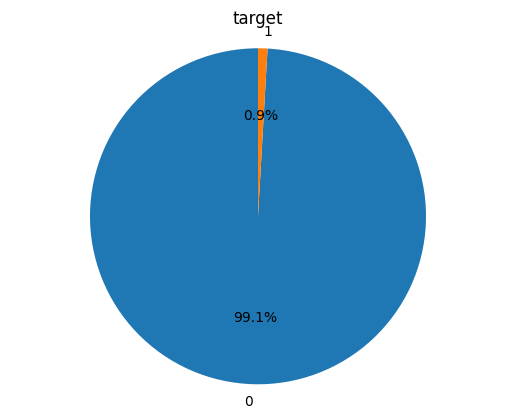

In [53]:
td = train_df['target'].value_counts()
plt.pie(td, startangle=90, autopct='%1.1f%%', labels=td.index)
plt.axis('equal')
plt.title('target')
plt.show()

**Ответ:** 0.9%

### Задание №2 в какой день недели Элис появилась в первый раз?

In [37]:
train_df[train_df.target == 1]

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
79635,270,2013-11-15 12:18:58,63,2013-11-15 12:21:25,21,2013-11-15 12:27:04,21,2013-11-15 12:27:05,22,2013-11-15 12:27:06,...,2013-11-15 12:27:25,21,2013-11-15 12:27:25,7832,2013-11-15 12:27:28,21,2013-11-15 12:27:28,30,2013-11-15 12:27:29,1
11791,7832,2013-11-15 12:27:29,29,2013-11-15 12:27:30,7832,2013-11-15 12:27:31,37,2013-11-15 12:27:32,7832,2013-11-15 12:27:41,...,2013-11-15 12:27:41,29,2013-11-15 12:27:41,7832,2013-11-15 12:27:47,30,2013-11-15 12:27:47,29,2013-11-15 12:27:47,1
250238,7832,2013-11-15 12:28:02,30,2013-11-15 12:28:02,29,2013-11-15 12:28:03,30,2013-11-15 12:28:09,7832,2013-11-15 12:28:09,...,2013-11-15 12:28:09,37,2013-11-15 12:28:18,21,2013-11-15 12:28:28,7832,2013-11-15 12:28:30,30,2013-11-15 12:28:30,1
72789,29,2013-11-15 12:28:30,37,2013-11-15 12:29:02,7832,2013-11-15 12:31:41,30,2013-11-15 12:31:41,29,2013-11-15 12:31:42,...,2013-11-15 12:31:53,30,2013-11-15 12:31:53,29,2013-11-15 12:31:53,7832,2013-11-15 12:32:06,30,2013-11-15 12:32:07,1
184885,29,2013-11-15 12:32:07,37,2013-11-15 12:32:28,29,2013-11-15 12:34:41,7832,2013-11-15 12:34:41,30,2013-11-15 12:34:41,...,2013-11-15 12:35:05,7832,2013-11-15 12:35:06,30,2013-11-15 12:35:07,29,2013-11-15 12:35:07,7832,2013-11-15 12:35:17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188473,37,2014-04-15 17:42:12,2271,2014-04-15 17:42:13,37,2014-04-15 17:42:32,656,2014-04-15 17:42:32,17283,2014-04-15 17:42:32,...,2014-04-15 17:42:33,656,2014-04-15 17:42:33,35,2014-04-15 17:42:34,17283,2014-04-15 17:42:34,233,2014-04-15 17:42:35,1
40139,29,2014-04-15 17:42:36,37,2014-04-15 17:42:37,2271,2014-04-15 17:42:38,21,2014-04-15 17:42:39,21,2014-04-15 17:42:46,...,2014-04-15 17:42:46,37,2014-04-15 17:42:46,18727,2014-04-15 17:42:47,38,2014-04-15 17:42:48,1444,2014-04-15 17:42:49,1
205622,18728,2014-04-15 17:42:49,1444,2014-04-15 17:42:50,157,2014-04-15 17:42:53,18727,2014-04-15 17:42:54,319,2014-04-15 17:42:55,...,2014-04-15 17:44:37,1444,2014-04-15 17:44:41,18727,2014-04-15 17:57:33,1444,2014-04-15 17:57:37,18727,2014-04-15 17:58:30,1


In [38]:
train_df['time1'].min().isoweekday()  #.isoweekday() - показывает день недели, где 1 - понедельник, 7 - воскресенье

5

**Ответ:** Пятница (2013-11-15 - 15 ноября 2013 года - пятница)

### Задание №3 Какие года присутствуют в обучающей выборке?

In [39]:
train_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
27554,41475,2013-11-15 07:39:35,6725,2013-11-15 07:39:35,6725,2013-11-15 07:39:36,41475,2013-11-15 07:39:36,41476,2013-11-15 07:39:40,...,2013-11-15 07:39:41,6725,2013-11-15 07:42:50,41475,2013-11-15 07:42:50,41476,2013-11-15 07:42:50,6725,2013-11-15 07:44:25,0
81350,41476,2013-11-15 07:44:25,41475,2013-11-15 07:44:25,41476,2013-11-15 07:57:45,6725,2013-11-15 07:57:45,41475,2013-11-15 07:57:45,...,2013-11-15 07:57:46,41476,2013-11-15 07:57:47,6725,2013-11-15 07:57:49,41475,2013-11-15 07:57:49,41476,2013-11-15 07:57:49,0
234665,4802,2013-11-15 07:52:17,23,2013-11-15 07:52:18,4803,2013-11-15 07:52:19,38,2013-11-15 07:52:19,38,2013-11-15 07:52:20,...,2013-11-15 07:52:20,4804,2013-11-15 07:52:23,21,2013-11-15 07:52:26,23,2013-11-15 07:52:26,22,2013-11-15 07:52:28,0
97610,23,2013-11-15 07:52:28,23,2013-11-15 07:52:29,22,2013-11-15 07:52:37,21,2013-11-15 07:52:37,63,2013-11-15 07:55:10,...,2013-11-15 07:55:10,784,2013-11-15 07:55:56,4804,2013-11-15 07:57:50,4804,2013-11-15 08:01:18,784,2013-11-15 08:01:26,0
161358,41476,2013-11-15 07:57:50,41476,2013-11-15 07:57:51,6725,2013-11-15 07:59:34,41475,2013-11-15 07:59:34,41476,2013-11-15 07:59:34,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129606,6003,2014-05-03 18:06:13,0,NaT,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
53628,6003,2014-05-03 18:09:26,0,NaT,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
84754,6003,2014-05-03 18:11:21,0,NaT,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0


In [40]:
train_df['time1'].groupby(train_df['time1'].dt.year).count()  # Группировка по году

time1
2013     74675
2014    178886
Name: time1, dtype: int64

In [55]:
train_df['time1'].groupby(train_df['time1'].dt.month).count() # Группировка по месяцу

time1
1     28058
2     53108
3     55275
4     42358
5        87
11    31118
12    43557
Name: time1, dtype: int64

**Ответ:** 2013, 2014

### Задание №4 Какой сайт в обучающей выборке чаще всего посещает первым Элис и обычный пользователь?

In [41]:
df = train_df[['site1', 'target']]
df_alice = df[df['target']==1]
df_user = df[df['target']==0]

In [42]:
df_alice  # Сайты, которые посещала Элис

,site1,target
session_id,,
79635,270,1
11791,7832,1
250238,7832,1
72789,29,1
184885,29,1
...,...,...
188473,37,1
40139,29,1
205622,18728,1


In [43]:
train_df[['site1', 'target']][train_df[['site1', 'target']]['target']==1]  # ↑ Тоже самое, но без сокращений

,site1,target
session_id,,
79635,270,1
11791,7832,1
250238,7832,1
72789,29,1
184885,29,1
...,...,...
188473,37,1
40139,29,1
205622,18728,1


In [44]:
df_user.value_counts(subset='site1').head(5)  # Топ 5 ПЕРВЫХ(site1) посещаемых сайтов пользователями (по количеству сессий)

site1
21     13794
23      9193
782     7769
29      5403
22      5378
dtype: int64

In [45]:
new_dict[21]  # Самый популярный сайт среди пользователей

'www.google.fr'

In [46]:
df_alice.value_counts(subset='site1').head(5)  # Топ 5 ПЕРВЫХ(site1) посещаемых сайтов Элис (по количеству сессий)

site1
80    142
77    141
76    130
29     98
21     80
dtype: int64

In [47]:
new_dict[80]  # Самый посещаемый сайт Элис

's.youtube.com'

**Ответ:** s.youtube.com, www.google.fr

### Задание №5 Какой сайт в обучающей выборке является вторым по популярности в 2014 году и сколько раз его посещали в 2014 году?

In [64]:
df_14 = train_df[train_df['time1'].dt.year == 2014]  # Создадим датафрейм с данными, начиная с 2014 года

In [76]:
all_sites = pd.concat([df_14['site1'], df_14['site2'], df_14['site3'], df_14['site4'], df_14['site5'], df_14['site6'], df_14['site7'], df_14['site8'], df_14['site9'], df_14['site10']], axis=0).reset_index(name='site')  # Создание датафрейма, который объединяет сессии всех сайтов в одну

In [75]:
all_sites

,session_id,site
0,228341,21
1,65195,1037
2,176539,820
3,12346,820
4,181211,820
...,...,...
1788855,129606,0
1788856,53628,0
1788857,84754,0
1788858,153398,0


In [67]:
all_sites.groupby('site', as_index=False).agg({'session_id': 'count'}).sort_values(by='session_id', ascending=False)  # Группировка и сортировка данных по убыванию популярности посещения сайтов

,site,session_id
21,21,86090
0,0,81887
779,782,77039
23,23,56333
777,780,40610
...,...,...
22872,28342,1
22873,28343,1
22874,28344,1
10774,12529,1


In [78]:
new_dict[782]  # Второй по посещаемости сайт среди всех в 2014 году (77039 посещений)

'annotathon.org'

**Ответ:** annotathon.org

### Задание №6 Сколько всего сессий обучающей выборки содержат в себе меньше чем 10 сайтов?

In [82]:
(train_df[sites]==0).any(axis=1).sum()

22509

### Задание №7 Выберите верные утверждения для обучающей выборки:

In [101]:
tr_ch = train_df.reset_index()  # train_df БЕЗ индекса сессии в начале

In [102]:
# В среднем Элис проводит меньше времени на первой странице, чем другие пользователи ДА
tr_ch['dif12'] = (train_df['time2'] - train_df['time1']).dt.seconds
tr_ch.groupby('target').agg({'dif12': 'mean'})

,dif12
target,
0,19.220060
1,16.832963


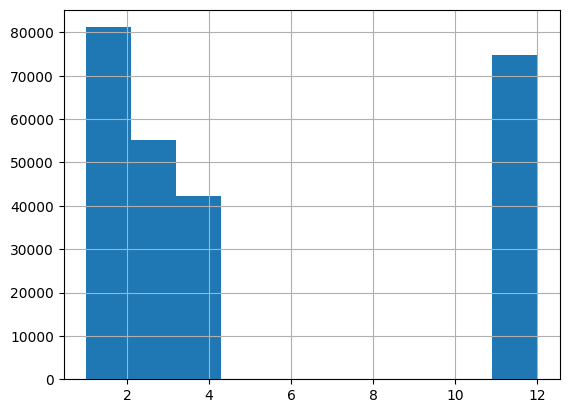

In [103]:
# Лето является самым малоактивным временем года вообще ДА
tr_ch['time1'].dt.month.hist()  # Вся активность
plt.show()

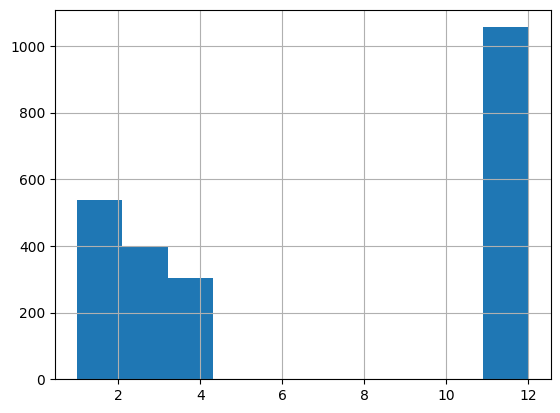

In [104]:
tr_ch['time1'][tr_ch['target']==1].dt.month.hist()  # Активность Элис
plt.show()

In [105]:
ev_s = tr_ch.groupby(tr_ch['time1'].dt.month).agg({'session_id': 'count'})  # Вся активность по месяцам
ev_s

,session_id
time1,
1,28058
2,53108
3,55275
4,42358
5,87
11,31118
12,43557


In [106]:
ev_s2 = tr_ch.groupby(tr_ch['time1'][tr_ch['target']==1].dt.month).agg({'session_id': 'count'})  # Активность Элис по месяцам
ev_s2

,session_id
time1,
1.0,88
2.0,449
3.0,399
4.0,305
11.0,446
12.0,610


In [107]:
# Медианная длительность посещения первой страницы в среднем больше, чем у Элис НЕТ
print(tr_ch.groupby('target').agg({'dif12': 'median'}))
print(tr_ch['dif12'].median())

        dif12
target       
0         1.0
1         1.0
1.0


In [112]:
# Элис наиболее активна в марте и неактивна летом НЕТ
ev_s2  # Активность Элис по месяцам

,session_id
time1,
1.0,88
2.0,449
3.0,399
4.0,305
11.0,446
12.0,610


In [113]:
tr_ch['time1'][tr_ch['target'] == 1].apply(lambda x: x.isoweekday()).value_counts() # Активность Элис по дням недели??

1    1315
2     526
5     308
4     110
3      38
Name: time1, dtype: int64

### Задание №8 Чему равное медианное значение количества уникальных сайтов в рамках одной сессии обучающей выборки?

In [114]:
dun = train_df[sites]
dun.nunique(axis=1).median()

6.0

### Задание №9 Чему равное медианное значение времени сессии в обучающей выборке (время посещения последнего сайта примем равным нулю)?

In [115]:
tr_ch['dif110'] = (train_df['time10'] - train_df['time1']).dt.seconds
tr_ch['dif110'].median()

27.0

### Задание №10  В каком месяце доля сессий Элис среди всех сессий наибольшая?

In [116]:
# #10) В каком месяце доля сессий Элис среди всех сессий наибольшая?
ev_s2['dol_alice'] = ev_s2['session_id'] * 100 / ev_s['session_id']
# # dol['alice'] =
# tr_ch[tr_ch['target']==1].groupby(tr_ch['time1'].dt.month).agg({'session_id': 'count'}).reset_index()
# # dol['res'] = dol['alice'] * 100 / dol['session_id']
# # # все - 100, элис - х
# # dol
ev_s2

,session_id,dol_alice
time1,,
1.0,88,0.313636
2.0,449,0.845447
3.0,399,0.721845
4.0,305,0.720053
11.0,446,1.433254
12.0,610,1.400464


**Ответ:** ноябрь